# Covariate data preprocessing

This section documents output from the factor analysis section (colored in orange) of command generator MWE and explained the purpose for each of the command. The file used in this page can be found at [here](https://drive.google.com/drive/folders/16ZUsciZHqCeeEWwZQR46Hvh5OtS8lFtA?usp=sharing).

**Each commands in the factor analysis tutorials will be generated once per theme. The MWE is considered a one theme analysis** 



> ../images/eqtl_command.png (254.4 KiB):

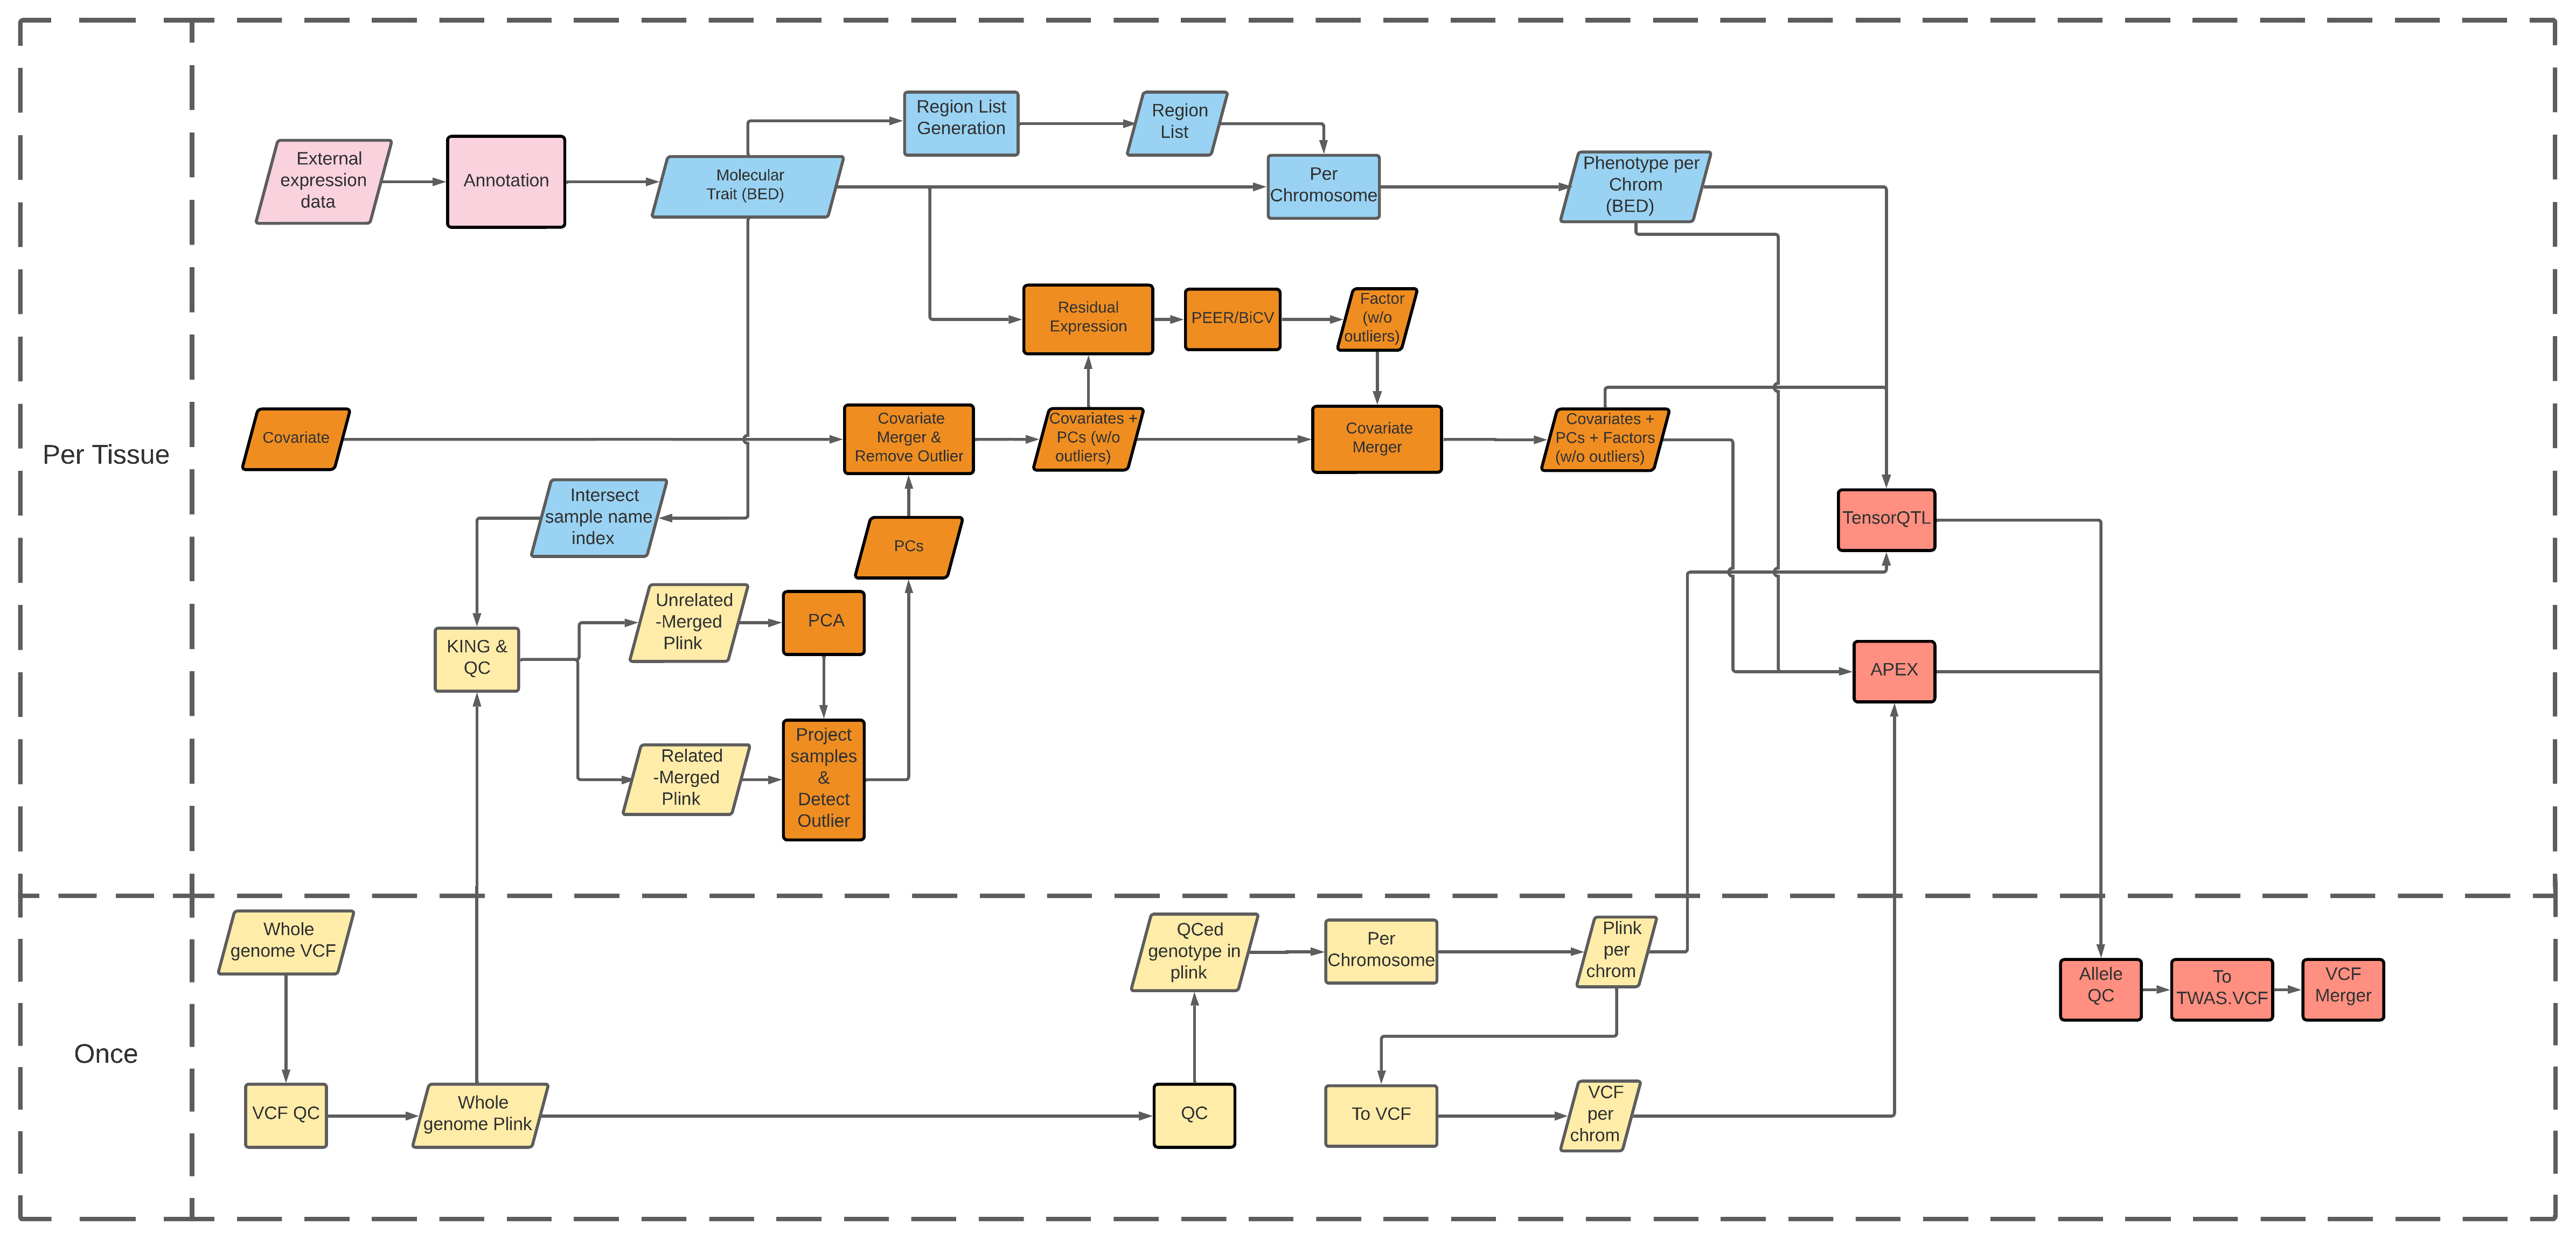

In [1]:
%preview ../images/eqtl_command.png

## PCA
The PCA was done based on the related/unrelated samples generated by [genotyoe preprocessing](https://github.com/cumc/xqtl-pipeline/blob/main/code/data_preprocessing/genotype_preprocessing.ipynb). PCs was estimated based on the unrelated sample, then the PCs for related sample will be calculated based on the estimated eigen loading from the unrelated sample. The PCs with a cumulative PVE of 70% will be used in determined outliner and used in downstream analysis.

In [ ]:
sos run pipeline/PCA.ipynb flashpca \
   --cwd output/data_preprocessing/MWE/pca output/data_preprocessing/MWE/pca \
   --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.unrelated.filtered.prune.bed \
   --container containers/flashpcaR.sif

The uniformly distributed PVE is due to [MAF filtering](https://github.com/cumc/brain-xqtl-analysis/blob/main/analysis/Wang_Columbia/snuc_pseudo_bulk/impact_on_pca_pve.ipynb)

> /mnt/mfs/statgen/snuc_pseudo_bulk/eight_tissue_analysis/MWE/QTL_association/output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.scree.png (56.7 KiB):

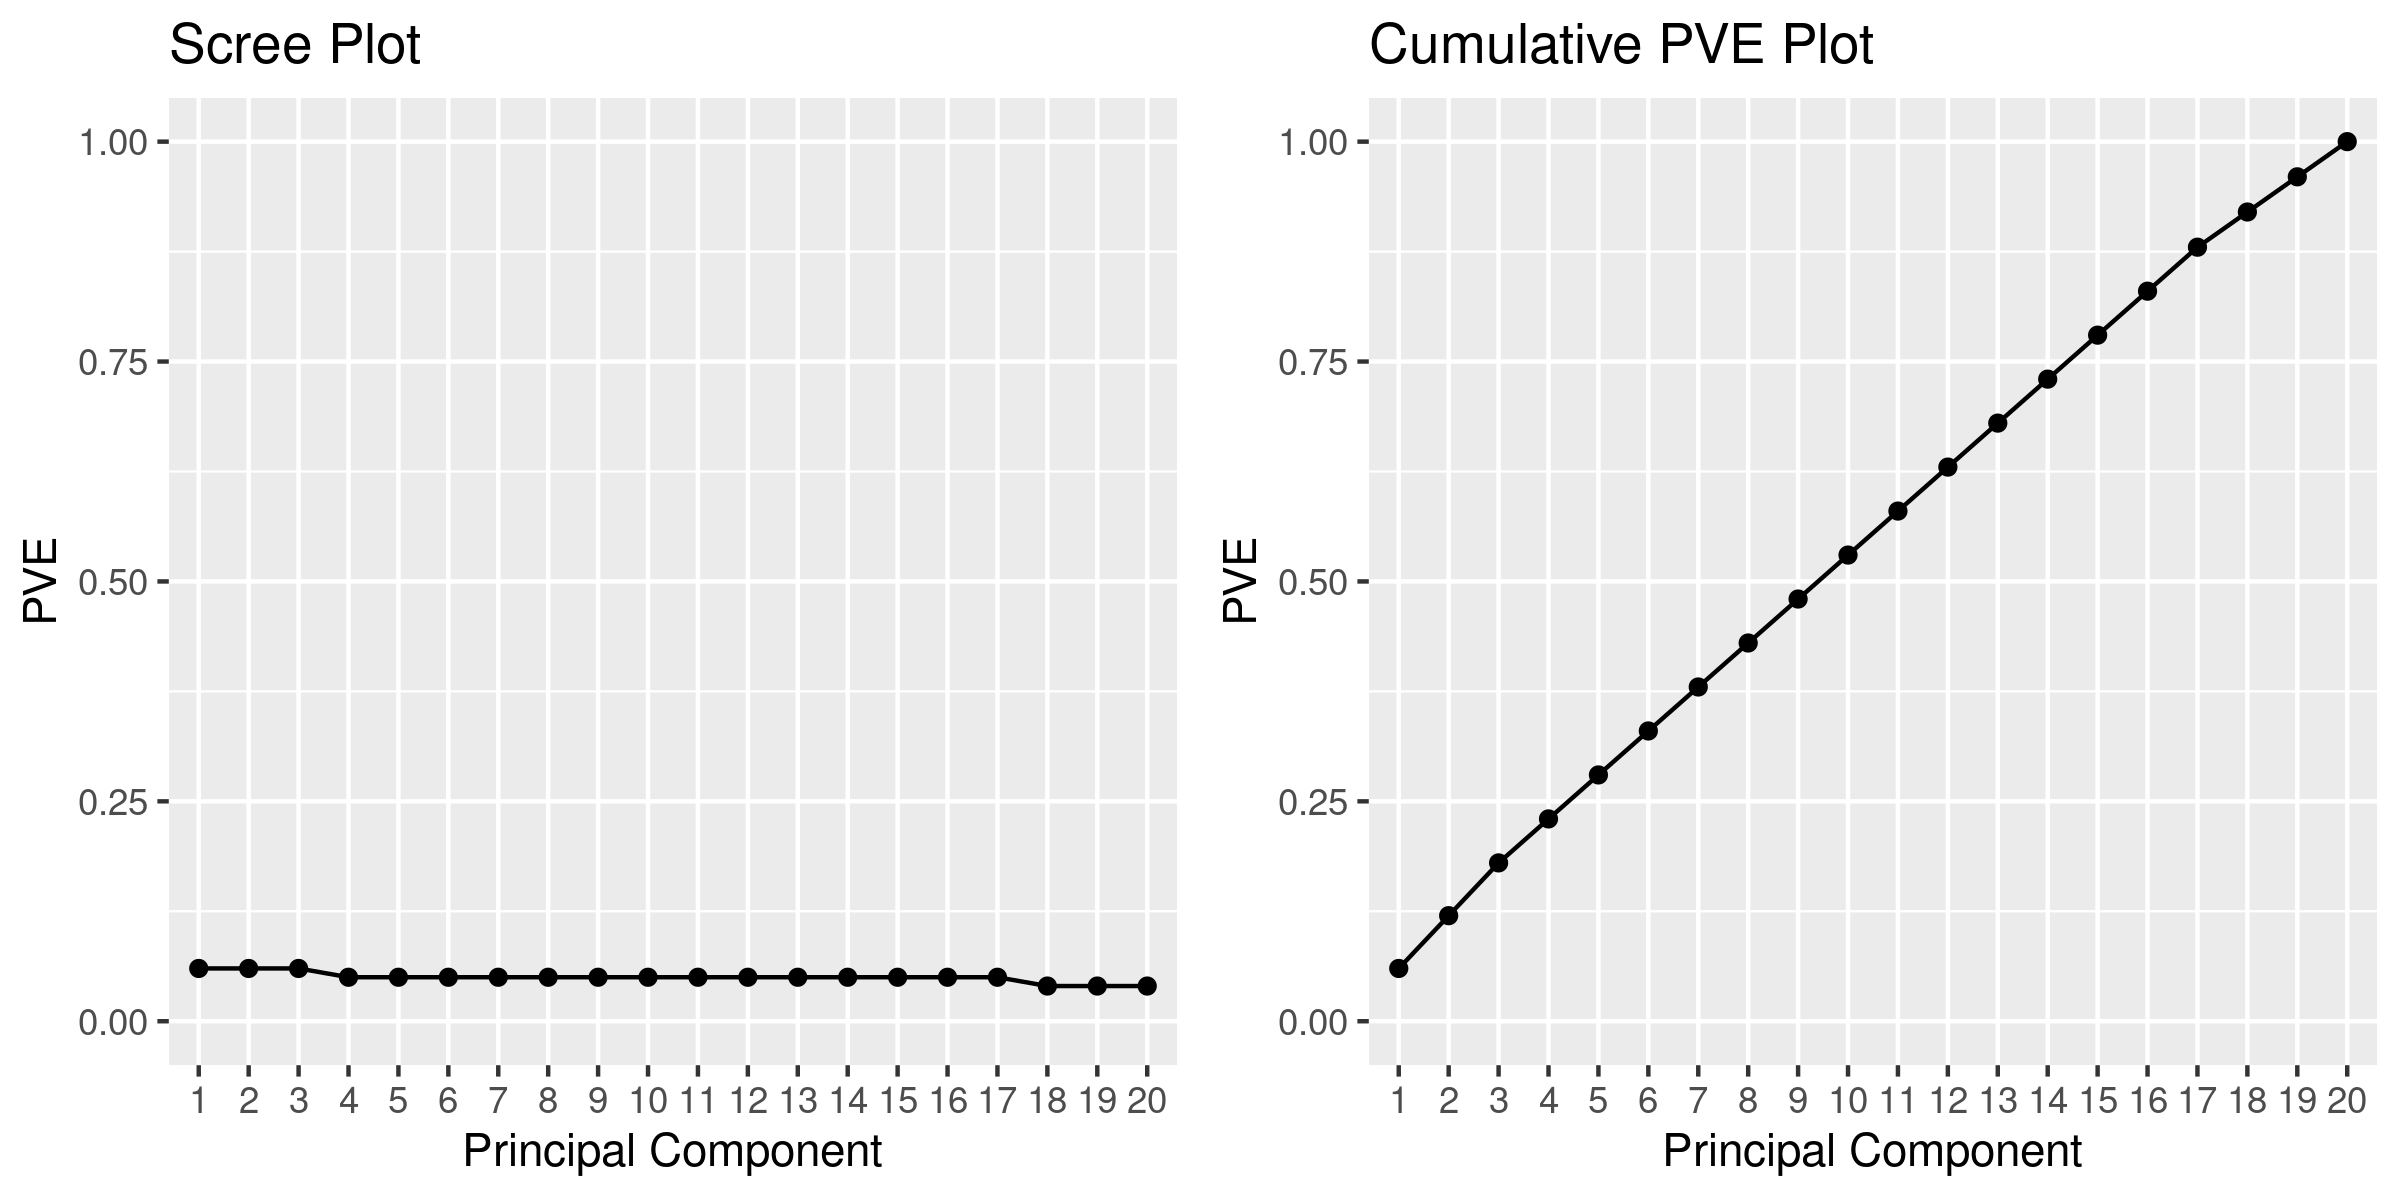

In [1]:
%preview data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.scree.png

In [ ]:
sos run pipeline/PCA.ipynb project_samples \
        --cwd output/data_preprocessing/MWE/pca output/data_preprocessing/MWE/pca \
        --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.related.filtered.extracted.bed \
        --pca-model  output/data_preprocessing/MWE/pca/MWE.MWE.unrelated.filtered.prune.pca.rds \
        --maha-k `awk '$3 < 0.7' output/data_preprocessing/MWE/pca/MWE.MWE.unrelated.filtered.prune.pca.scree.txt | tail -1 | cut -f 1  ` \
        --container containers/flashpcaR.sif

> /mnt/mfs/statgen/snuc_pseudo_bulk/eight_tissue_analysis/MWE/QTL_association/output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.pc.png (1.5 MiB):

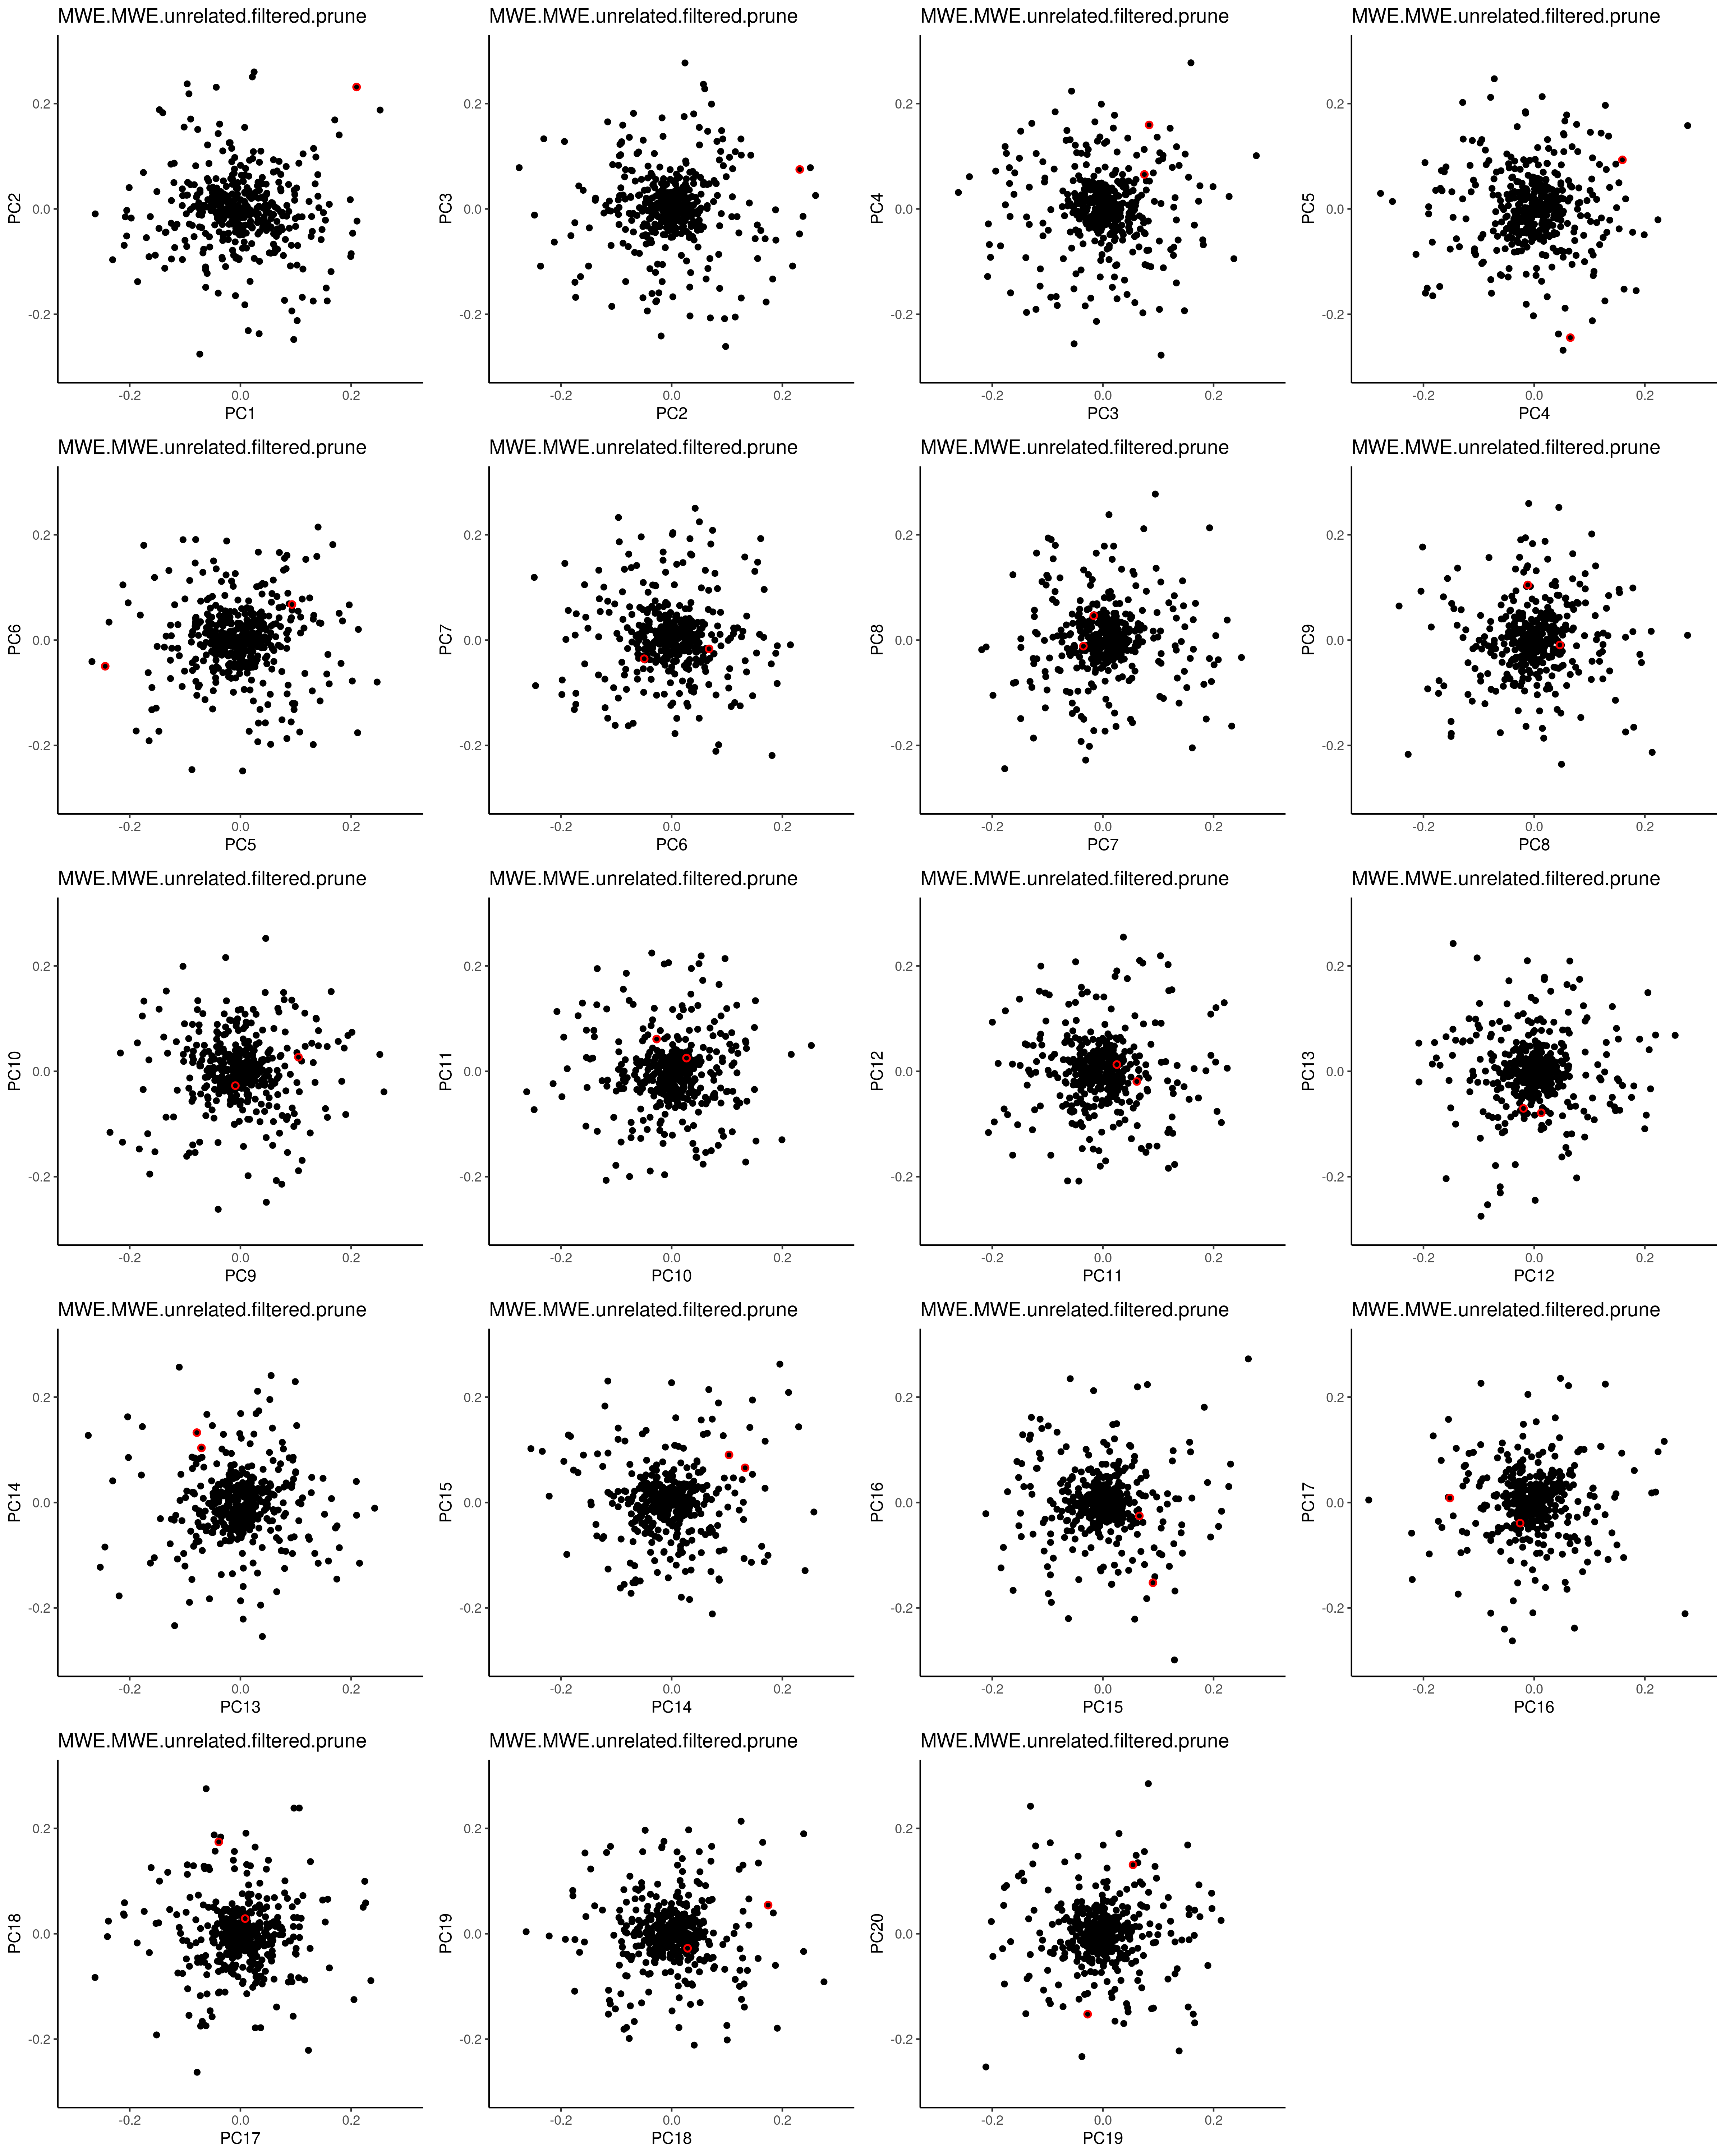

In [2]:
%preview data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.pc.png

## Merge covariate
This step generate a concatanated principle component + covaraiate (pc-cov) matrixs so that we can use it to generate a residual phenotype, as outlined in the [phenotype processing]() page

The tolerance for sample-wide NA rate of any covariates/pc are specified by `tol_cov`.  -1 means quit, otherwise for covariate with missing rate larger than tol_cov will be removed, with missing rate smaller than tol_cov will be mean_imputed.

The first k PCs that satisfied >70% PVE will be merged with the covariates for downstream analysis and for estimating the residual expression in the `phenotype_preprocessing` section.

In [ ]:
sos run pipeline/covariate_formatting.ipynb merge_pca_covariate \
        --cwd output/data_preprocessing/MWE/covariates \
        --pcaFile data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.rds \
        --covFile  MWE.covariate.cov.gz \
        --tol_cov 0.3  \
        --k `awk '$3 < 0.7' output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.scree.txt | tail -1 | cut -f 1 ` \
        --container containers/bioinfo.sif  --outliersFile data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.outliers

### Removal of outliers
At this step, based on the output plot of PCA step, the user can decide if outliers should be removed. By default, the `outlierFile` will be filled, but the user have to manually add the `--remove-outliers` flag which will remove all the samples ID in the second column of the `.outlier` file from the header of pc-cov matrix, effectively remove them from all down stream analysis.

In [ ]:
sos run pipeline/covariate_formatting.ipynb merge_pca_covariate \
        --cwd output/data_preprocessing/MWE/covariates \
        --pcaFile data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.rds \
        --covFile  MWE.covariate.cov.gz \
        --tol_cov 0.3  \
        --k `awk '$3 < 0.7' output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.scree.txt | tail -1 | cut -f 1 ` \
        --container containers/bioinfo.sif  --outliersFile data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.outliers --remove-outliers

## Factor Analysis
The [residual expression](https://github.com/cumc/xqtl-pipeline/blob/main/code/data_preprocessing/phenotype_preprocessing.ipynb) will be used to conduct the factor analysis using either [BiCV (APEX)](https://corbinq.github.io/apex/) or [PEER (MOFA2)](https://biofam.github.io/MOFA2/). The purpose of factor analysis is to uncovered un-measured factor embedded in the phenotype data, potentiall factor could be experiment batch effct, or unmeasure morbidity of the sampels .etc.

The primary factor analysis method we used in our analysis is PEER.

In [ ]:
sos run pipeline/BiCV_factor.ipynb BiCV \
   --cwd output/data_preprocessing/MWE/covariates \
   --phenoFile data_preprocessing/MWE/phenotype/MWE.log2cpm.MWE.covariate.cov.MWE.MWE.related.filtered.extracted.pca.projected.resid.bed.gz  \
   --container containers/APEX.sif  \
   --walltime 24h \
   --numThreads 8 \
   --iteration 1000 \
   --N 10

In [ ]:
sos run pipeline/PEER_factor.ipynb PEER \
   --cwd output/data_preprocessing/MWE/covariates \
   --phenoFile data_preprocessing/MWE/phenotype/MWE.log2cpm.MWE.covariate.cov.MWE.MWE.related.filtered.extracted.pca.projected.resid.bed.gz  \
   --container containers/PEER.sif  \
   --walltime 24h \
   --numThreads 8 \
   --iteration 1000 \
   --N 10

## Merged factor & covariates
The factors estimated above will be concatanated with pc-cov matrix for downstream analysis as a complete covariate matrix. 

In [ ]:
sos run pipeline/covariate_formatting.ipynb merge_factor_covariate \
        --cwd output/data_preprocessing/MWE/covariates \
        --factorFile data_preprocessing/MWE/covariates/MWE.log2cpm.MWE.covariate.cov.MWE.MWE.related.filtered.extracted.pca.projected.resid.bed.PEER.cov.gz \
        --covFile  data_preprocessing/MWE/covariates/MWE.covariate.cov.MWE.MWE.related.filtered.extracted.pca.projected.gz \
        --container containers/bioinfo.sif